In [2]:
pip install pandas numpy xgboost imbalanced-learn cupy-cuda11x scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 MB 10.0 MB/s eta 0:00:00


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import time
from joblib import parallel_backend
import cupy

# --------------------------
# Data Loading & Preparation
# --------------------------
df = pd.read_csv('pdc_dataset_with_target.csv')

def preprocess_data(df):
    # Handle missing values
    for col in ['feature_1', 'feature_2', 'feature_4', 'feature_7']:
        df[col].fillna(df[col].mean(), inplace=True)
    # Encode categoricals
    df['feature_5'] = df['feature_5'].map({'Yes': 1, 'No': 0})
    df = pd.get_dummies(df, columns=['feature_3'], prefix='feature_3', dtype=int)
    return df

df = preprocess_data(df)
X = df.drop('target', axis=1)
y = df['target']

# --------------------
# Class Balance Check
# --------------------
print("Class Distribution:\n", y.value_counts(normalize=True))
use_smote = (y.value_counts().min() / y.value_counts().max() < 0.2)
if use_smote:
    print("Applying SMOTE for class balance")

# --------------------
# GPU Configuration
# --------------------
def gpu_check():
    try:
        print("XGBoost GPU Support:", xgb.build_info()['USE_CUDA'])
        _ = cupy.zeros(1)  # Warm-up GPU
        return True
    except:
        print("GPU not available - using CPU")
        return False

gpu_available = gpu_check()

# --------------------
# Critical Fix: Outlier Handling
# --------------------
class SafeDataPreprocessor:
    def __init__(self, numeric_cols):
        self.numeric_cols = numeric_cols
        self.bounds = {}

    def fit_transform(self, X, y):
        # Calculate IQR bounds
        for col in self.numeric_cols:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            self.bounds[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        # Filter data
        mask = np.ones(len(X), dtype=bool)
        for col in self.numeric_cols:
            low, high = self.bounds[col]
            mask &= (X[col] >= low) & (X[col] <= high)
        return X[mask], y[mask]

# --------------------
# Optimized Pipeline
# --------------------
def create_safe_pipeline(use_gpu):
    base_params = {
        'n_estimators': 300,
        'learning_rate': 0.1,
        'max_depth': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42,
        'scale_pos_weight': len(y[y == 0]) / len(y[y == 1])
    }
    if use_gpu and gpu_available:
        base_params.update({
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor'
        })
    else:
        base_params['tree_method'] = 'hist'

    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]
    if use_smote:
        steps.insert(0, ('smote', SMOTE(random_state=42)))
    steps.append(('xgb', xgb.XGBClassifier(**base_params)))
    return ImbPipeline(steps)



# --------------------
# Training & Evaluation
# --------------------
def run_safe_experiment(use_gpu, parallel=True):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Outlier removal
    preprocessor = SafeDataPreprocessor(
        ['feature_1', 'feature_2', 'feature_4', 'feature_6', 'feature_7']
    )
    X_train, y_train = preprocessor.fit_transform(X_train, y_train)
    backend = 'threading' if parallel else 'sequential'
    with parallel_backend(backend, n_jobs=-1 if parallel else 1):
        pipeline = create_safe_pipeline(use_gpu)
        param_grid = {
            'xgb__max_depth': [3, 5],
            'xgb__learning_rate': [0.05, 0.1]
        }
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            scoring='f1',
            cv=3,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
    return {
        'time': time.time() - start_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

# --------------------
# Run Experiments
# --------------------
configurations = [
    {'name': 'GPU_Parallel',  'gpu': True,  'parallel': True},
    {'name': 'CPU_Parallel',  'gpu': False, 'parallel': True},
    {'name': 'CPU_Serial',    'gpu': False, 'parallel': False}
]

results = {}
for config in configurations:
    print(f"\n⏳ Running {config['name']} configuration...")
    try:
        results[config['name']] = run_safe_experiment(
            config['gpu'], config['parallel']
        )
        print(f"✅ {config['name']} completed")
    except Exception as e:
        print(f"❌ Error in {config['name']}: {str(e)}")

# --------------------
# Display Results
# --------------------
if results:
    print("\n📊 Final Results:")
    print("=" * 60)
    for name, res in results.items():
        print(f"\n🏷️ Configuration: {name}")
        print(f"⏱️ Time:       {res['time']:.2f}s")
        print(f"🎯 Accuracy:   {res['accuracy']:.4f}")
        print(f"📈 F1 Score:   {res['f1']:.4f}")
        print(f"📊 ROC AUC:    {res['roc_auc']:.4f}")
        print("🔄 Confusion Matrix:")
        print(res['confusion_matrix'])
        print("⚙️ Best Params:")
        print(res['best_params'])
        print("-" * 60)
else:
    print("\n❌ All configurations failed. Check error messages above.")


<ipython-input-28-a272982116bd>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Class Distribution:
 target
0    0.602
1    0.398
Name: proportion, dtype: float64
XGBoost GPU Support: True

⏳ Running GPU_Parallel configuration...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


✅ GPU_Parallel completed

⏳ Running CPU_Parallel configuration...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ CPU_Parallel completed

⏳ Running CPU_Serial configuration...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

✅ CPU_Serial completed

📊 Final Results:

🏷️ Configuration: GPU_Parallel
⏱️ Time:       5.28s
🎯 Accuracy:   0.5076
📈 F1 Score:   0.4290
📊 ROC AUC:    0.5002
🔄 Confusion Matrix:
[[2645 2282]
 [1756 1517]]
⚙️ Best Params:
{'xgb__learning_rate': 0.05, 'xgb__max_depth': 3}
------------------------------------------------------------

🏷️ Configuration: CPU_Parallel
⏱️ Time:       7.39s
🎯 Accuracy:   0.5165
📈 F1 Score:   0.4402
📊 ROC AUC:    0.5097
🔄 Confusion Matrix:
[[2676 2251]
 [1714 1559]]
⚙️ Best Params:
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3}
------------------------------------------------------------

🏷️ Configuration: CPU_Serial
⏱️ Time:       6.01s
🎯 Accuracy:   0.5165
📈 F1 Score:   0.4402
📊 ROC AUC:    0.5097
🔄 Confusion Matrix:
[[2676 2251]
 [1714 1559]]
⚙️ Best Params:
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3}
------------------------------------------------------------


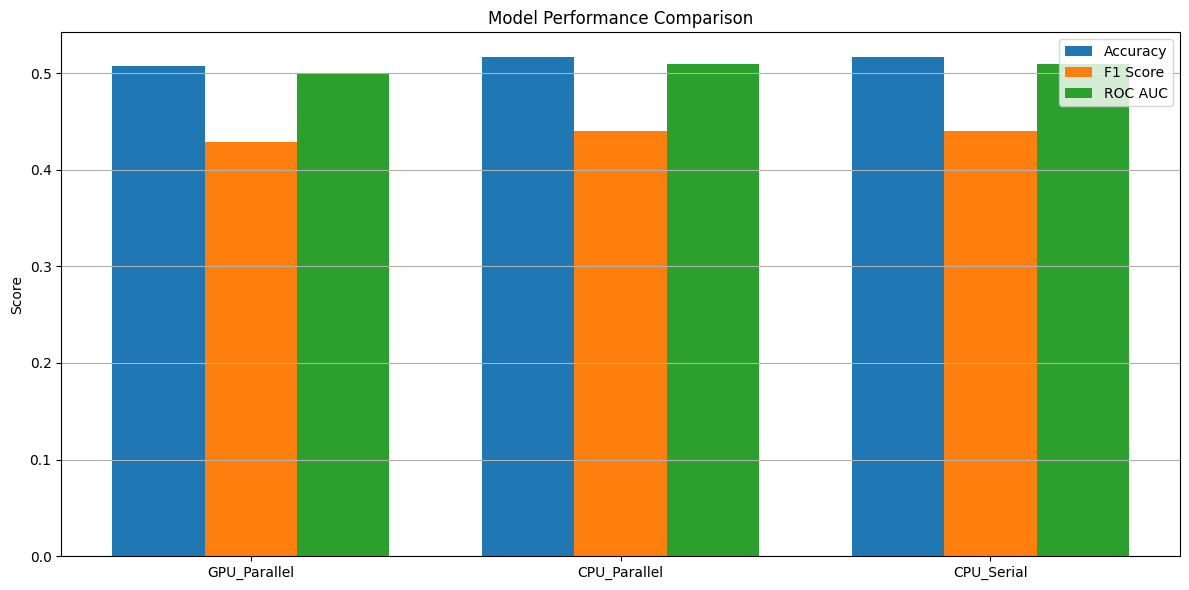

<ipython-input-4-f1adaf06c261>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=configs, y=times, palette='viridis')


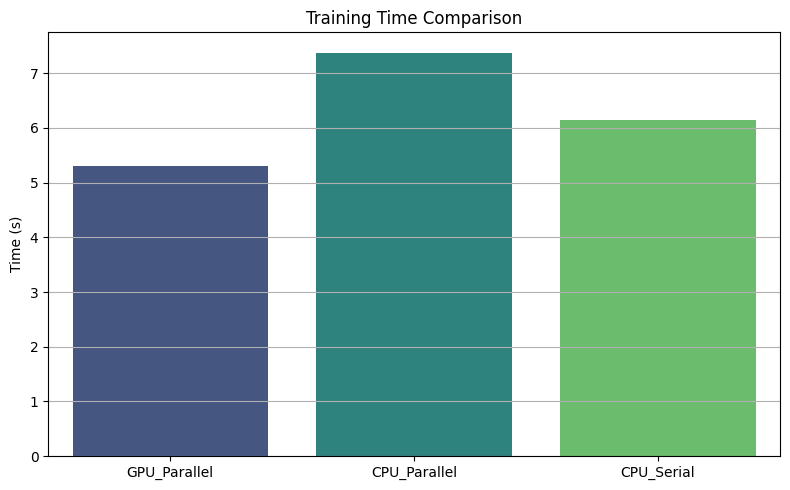

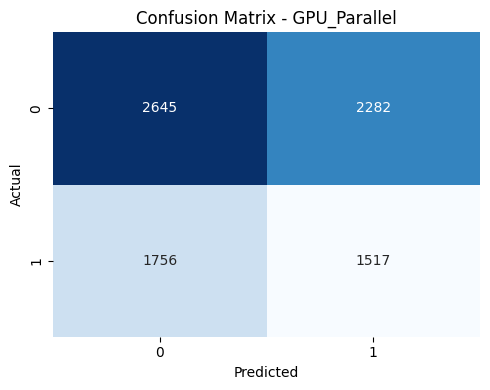

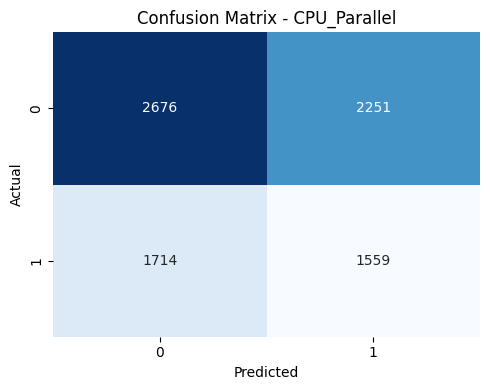

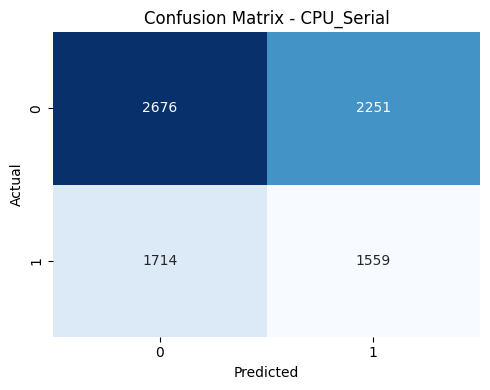

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
configs = list(results.keys())
accuracies = [results[c]['accuracy'] for c in configs]
f1_scores = [results[c]['f1'] for c in configs]
roc_aucs = [results[c]['roc_auc'] for c in configs]
times = [results[c]['time'] for c in configs]

# 1. Accuracy, F1 Score, ROC AUC comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(configs))
width = 0.25
plt.bar(x - width, accuracies, width, label='Accuracy')
plt.bar(x, f1_scores, width, label='F1 Score')
plt.bar(x + width, roc_aucs, width, label='ROC AUC')
plt.xticks(x, configs)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Training Time comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=configs, y=times, palette='viridis')
plt.ylabel("Time (s)")
plt.title("Training Time Comparison")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 3. Confusion Matrix Heatmaps
for config in configs:
    cm = results[config]['confusion_matrix']
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {config}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


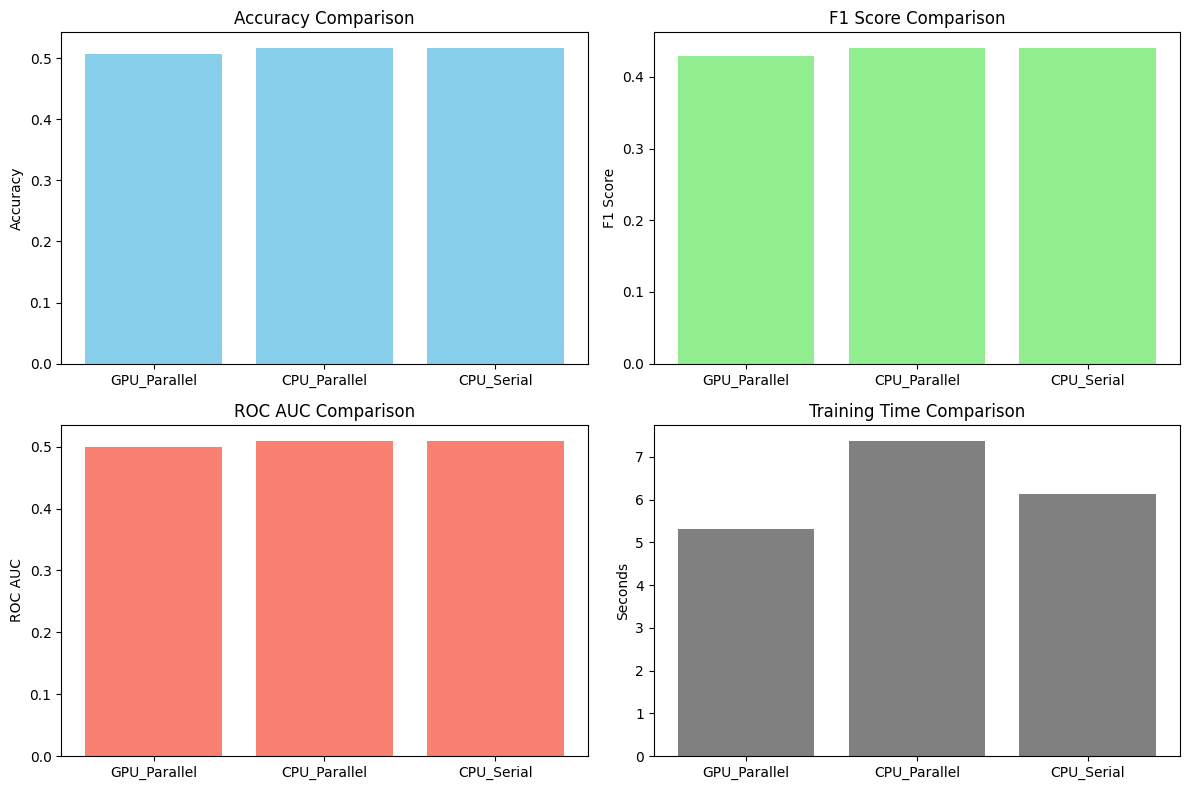

In [5]:
import matplotlib.pyplot as plt

configs = list(results.keys())
accuracies = [results[c]['accuracy'] for c in configs]
f1_scores = [results[c]['f1'] for c in configs]
roc_aucs = [results[c]['roc_auc'] for c in configs]
times = [results[c]['time'] for c in configs]

plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.bar(configs, accuracies, color='skyblue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

# F1 Score
plt.subplot(2, 2, 2)
plt.bar(configs, f1_scores, color='lightgreen')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')

# ROC AUC
plt.subplot(2, 2, 3)
plt.bar(configs, roc_aucs, color='salmon')
plt.title('ROC AUC Comparison')
plt.ylabel('ROC AUC')

# Time
plt.subplot(2, 2, 4)
plt.bar(configs, times, color='gray')
plt.title('Training Time Comparison')
plt.ylabel('Seconds')

plt.tight_layout()
plt.show()
